**Data Preprocessing - Rafi**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import MinMaxScaler

In [2]:
# read values and labels, group by id to ensure columns are matching
values=pd.read_csv('training_values.csv')
labels=pd.read_csv('training_labels.csv')
df = values.merge(labels, on='id')

In [3]:
# dataset uses 0.0 to represent NaN values, replace it with np.nan to allow us to impute data easier
df['gps_height'].replace(0.0, np.nan, inplace=True)
df['population'].replace(0.0, np.nan, inplace=True)
df['amount_tsh'].replace(0.0, np.nan, inplace=True)
df['longitude'].replace(0.0, np.nan, inplace=True)
df['latitude'].replace(0.0, np.nan, inplace=True)
df['construction_year'].replace(0.0, np.nan, inplace=True)

In [4]:
# create two new variables, waterpoint_age and days_since_recorded as models do not like datetime data
current_year = datetime.datetime.now().year
df['waterpoint_age'] = current_year - df['construction_year']
current_date = datetime.datetime.now()
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
df['days_since_recorded'] = (current_date - df['date_recorded']).dt.days


In [5]:
# fill na values in true / false columns as false
df['permit'] = df['permit'].fillna(False)
df['public_meeting'] = df['public_meeting'].fillna(False)

In [6]:
# turn all string values lowercase for consistency 
string_columns = df.select_dtypes(include='object').columns
df[string_columns] = df[string_columns].apply(lambda x: x.str.lower())
df["funder"].fillna("other", inplace=True)
df["subvillage"].fillna("other", inplace=True)
df["wpt_name"].fillna("other", inplace=True)
df["scheme_management"].fillna("other", inplace=True)
df['installer'].fillna("other", inplace=True)
df["scheme_name"].fillna("other", inplace=True)

In [7]:
# drop uneccesary features
df.drop('management_group',axis=1,inplace=True) # similar values found in 'managment'
df.drop('extraction_type_group',axis=1,inplace=True) # similar values found in 'extraction_type_class'
df.drop('scheme_name',axis=1,inplace=True) # similar values found in 'scheme_managment'
df.drop('payment',axis=1,inplace=True) # similar values found in 'payment_type'
df.drop('quality_group',axis=1,inplace=True) # similar values found in 'quality_group'
df.drop('quantity_group',axis=1,inplace=True) # similar values found in 'quantity'
df.drop('source_type',axis=1,inplace=True) # similar values found in 'source'
df.drop('waterpoint_type_group',axis=1,inplace=True) # similar values found in 'waterpoint_type'
df.drop('date_recorded',axis=1,inplace=True)
df.drop('construction_year',axis=1,inplace=True)
df.drop('ward',axis=1,inplace=True)
df.drop('installer',axis=1,inplace=True) 
df.drop('permit', axis=1, inplace=True)
df.drop('id',axis=1,inplace=True)

In [8]:
train = df.copy()
label = train.pop('status_group')

In [9]:
# turn all categorical values into numerical so it works with models correctly
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for column_name in train.columns:
    if train[column_name].dtype == object:
        train[column_name] = le.fit_transform(train[column_name])
    else:
        pass

In [10]:
# create our testing and training splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2, random_state=42)

In [11]:
# data imputation - replace NaN values for numerical column with mean of its region (or just mean if region data doesnt exist)
X_train["gps_height"].fillna(X_train.groupby(['region'])["gps_height"].transform("mean"), inplace=True)
X_train["gps_height"].fillna(X_train["gps_height"].mean(), inplace=True)

X_train["population"].fillna(X_train.groupby(['region'])["population"].transform("mean"), inplace=True)
X_train["population"].fillna(X_train["population"].mean(), inplace=True)

X_train["amount_tsh"].fillna(X_train.groupby(['region'])["amount_tsh"].transform("mean"), inplace=True)
X_train["amount_tsh"].fillna(X_train["amount_tsh"].mean(), inplace=True)

X_train["waterpoint_age"].fillna(X_train.groupby(['region'])["waterpoint_age"].transform("mean"), inplace=True)
X_train["waterpoint_age"].fillna(X_train["waterpoint_age"].mean(), inplace=True)

X_train["longitude"].fillna(X_train.groupby(['region'])["longitude"].transform("mean"), inplace=True)

In [12]:
# do the same for test values - do seperate to ensure no data leakage
X_test["gps_height"].fillna(X_test.groupby(['region'])["gps_height"].transform("mean"), inplace=True)
X_test["gps_height"].fillna(X_test["gps_height"].mean(), inplace=True)

X_test["population"].fillna(X_test.groupby(['region'])["population"].transform("mean"), inplace=True)
X_test["population"].fillna(X_test["population"].mean(), inplace=True)

X_test["amount_tsh"].fillna(X_test.groupby(['region'])["amount_tsh"].transform("mean"), inplace=True)
X_test["amount_tsh"].fillna(X_test["amount_tsh"].mean(), inplace=True)

X_test["waterpoint_age"].fillna(X_test.groupby(['region'])["waterpoint_age"].transform("mean"), inplace=True)
X_test["waterpoint_age"].fillna(X_test["waterpoint_age"].mean(), inplace=True)

X_test["longitude"].fillna(X_test.groupby(['region'])["longitude"].transform("mean"), inplace=True)

**Model Training and Results - Rafi**

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report 
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV 
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [14]:
# try random forest (no hyperparm optimisation)
rf_model = RandomForestClassifier(n_jobs = -1)

In [19]:
rf_model.fit(X_train, y_train)
y_pred_rf_no_opt = rf_model.predict(X_test)
accuracy_rf_no_opt = accuracy_score(y_test, y_pred_rf_no_opt)
f1_rf_no_opt = f1_score(y_test, y_pred_rf_no_opt, average='weighted')
print("Accuracy Score: ", accuracy_rf_no_opt)
print("F1 Score: ", f1_rf_no_opt)

Accuracy Score:  0.8132154882154882
F1 Score:  0.8064106808171868


In [20]:
# perform hyperparam tuning on randomforest

param_grid = { 
    'n_estimators': [100,250,500,1000,2000], 
    'max_features': ['sqrt', 'log2'], 
    'max_depth': [None,25,50,100], 
    'n_jobs': [-1] 
} 

In [21]:
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv = 3) 
grid_search_rf.fit(X_train, y_train) 

NameError: name 'grid_search' is not defined

In [22]:
print(grid_search_rf.best_estimator_) 

RandomForestClassifier(max_depth=25, n_estimators=500, n_jobs=-1)


In [25]:
results = pd.DataFrame(grid_search_rf.cv_results_)
columns = ['param_n_estimators', 'param_max_features', 'mean_test_score', 'std_test_score']
results_sorted = results[columns].sort_values(by='mean_test_score', ascending=False)
results_sorted.head(10)
results.to_csv('hypertune_random_forest.csv')

In [26]:
# have best hyper params test with cross validation
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=500,max_depth=25,max_features='sqrt', n_jobs = -1)
scores = cross_val_score(rf, X_train, y_train, cv=5)
# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Calculate and print the mean score
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.80902778 0.80608165 0.80997475 0.81197391 0.80850168]
Mean accuracy: 0.8091119528619529


In [28]:
from sklearn.metrics import accuracy_score
best_rf = RandomForestClassifier(n_estimators=500,max_depth=25,max_features='sqrt', n_jobs = -1)
best_rf.fit(X_train, y_train)
best_rf_y_pred = best_rf.predict(X_test)
accuracy_best_rf = accuracy_score(y_test, best_rf_y_pred)
f1_score_best_rf = f1_score(y_test, best_rf_y_pred, average='weighted')
print("Accuracy:", accuracy_best_rf)
print("F1 Score: ", f1_score_best_rf)

Accuracy: 0.8153198653198653
F1 Score:  0.807161441721984


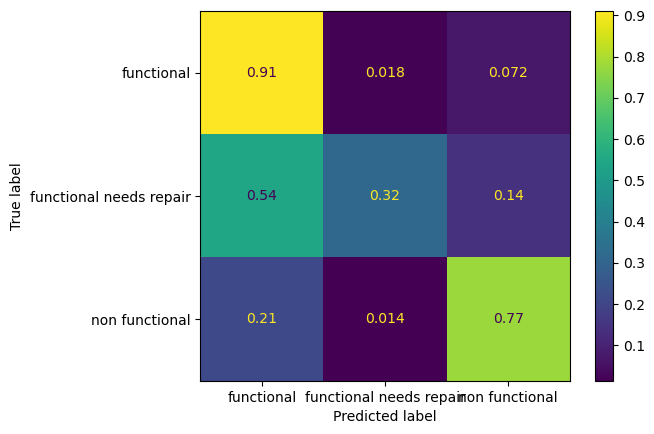

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_best_rf = confusion_matrix(y_test, best_rf_y_pred, normalize='true', labels = best_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_best_rf, display_labels = best_rf.classes_)
disp.plot()

In [42]:
# lets try catboost
from catboost import CatBoostClassifier
catboost = CatBoostClassifier(task_type="GPU") # utilise gpu to speed up training
catboost.fit(X_train, y_train,verbose=False)
y_pred_cb_no_opt = catboost.predict(X_test)
accuracy_cb_no_opt = accuracy_score(y_test, y_pred_cb_no_opt)
f1_cb_no_opt = f1_score(y_test, y_pred_cb_no_opt, average='weighted')
print("Accuracy:", accuracy_cb_no_opt)
print("F1 Score:", f1_cb_no_opt)



Accuracy: 0.8009259259259259
F1 Score: 0.7889727842669786


In [43]:
# performs good, lets see if hyper param tuning can fix
grid_cb = {'max_depth': [4,8,12],'n_estimators':[100, 500, 1000], 'verbose':[False]}
gs_cv_cb = GridSearchCV (estimator = catboost, param_grid = grid_cb, scoring ='accuracy', cv = 3)
gs_cv_cb.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001E588FC26A0>,
             param_grid={'max_depth': [4, 8, 12],
                         'n_estimators': [100, 500, 1000], 'verbose': [False]},
             scoring='accuracy')

In [47]:
results_cb = pd.DataFrame(gs_cv_cb.cv_results_)
results_cb.head(10)
results_cb_sorted = results_cb.sort_values(by='rank_test_score', ascending=False)
results_cb_sorted.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_verbose,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.976881,0.100036,0.023005,0.002945,4,100,False,"{'max_depth': 4, 'n_estimators': 100, 'verbose...",0.767740,0.774053,0.770644,0.770812,0.002580,9
6,7.642856,0.027583,0.023672,0.000471,12,100,False,"{'max_depth': 12, 'n_estimators': 100, 'verbos...",0.780177,0.783775,0.781818,0.781923,0.001471,8
1,2.923332,0.180164,0.025005,0.000817,4,500,False,"{'max_depth': 4, 'n_estimators': 500, 'verbose...",0.781818,0.786932,0.783586,0.784112,0.002121,7
7,35.778427,0.148176,0.052011,0.003560,12,500,False,"{'max_depth': 12, 'n_estimators': 500, 'verbos...",0.784912,0.785669,0.786932,0.785838,0.000833,6
8,71.204593,0.105864,0.088353,0.008342,12,1000,False,"{'max_depth': 12, 'n_estimators': 1000, 'verbo...",0.783333,0.785985,0.788258,0.785859,0.002012,5
3,1.469800,0.015092,0.020671,0.002056,8,100,False,"{'max_depth': 8, 'n_estimators': 100, 'verbose...",0.784848,0.790152,0.786301,0.787100,0.002238,4
2,4.950136,0.031370,0.033007,0.001634,4,1000,False,"{'max_depth': 4, 'n_estimators': 1000, 'verbos...",0.786111,0.789710,0.786806,0.787542,0.001559,3
4,6.193737,0.037271,0.028339,0.002055,8,500,False,"{'max_depth': 8, 'n_estimators': 500, 'verbose...",0.788699,0.793876,0.792929,0.791835,0.002251,2
5,11.430652,0.065261,0.033007,0.001415,8,1000,False,"{'max_depth': 8, 'n_estimators': 1000, 'verbos...",0.792424,0.797854,0.793119,0.794465,0.002412,1


In [51]:
# max_depth = 8 and n_estimators = 1000 performed best in tuning 
cb_best = CatBoostClassifier(task_type="GPU",max_depth = 8,n_estimators=1000)
cb_best.fit(X_train, y_train,verbose=False)
y_pred_cb_best = cb_best.predict(X_test)
accuracy_cb_best = accuracy_score(y_test, y_pred_cb_no_opt)
f1_cb_best = f1_score(y_test, y_pred_cb_best, average='weighted')
print("Accuracy:", accuracy_cb_best)
print("F1 Score:", f1_cb_best)


Accuracy: 0.8009259259259259
F1 Score: 0.7917063671801157


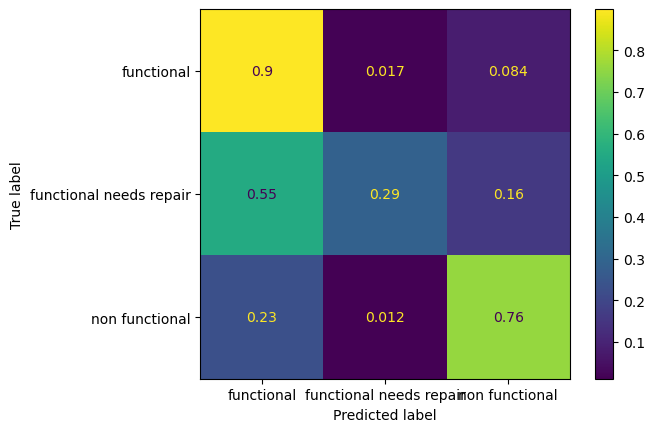

In [52]:
cm_best_cb = confusion_matrix(y_test, y_pred_cb_best, normalize='true', labels = cb_best.classes_)
disp_cb = ConfusionMatrixDisplay(confusion_matrix = cm_best_cb, display_labels = cb_best.classes_)
disp_cb.plot()

In [53]:
# create new dataframe to hold values, ground truth and predictions for both models
X_test_plot = X_test.copy()

X_test_plot['preds_best_rf'] = best_rf_y_pred
X_test_plot['preds_best_cb'] = y_pred_cb_best
X_test_plot['labels'] = y_test
X_test_plot['correct_classification_rf'] = X_test_plot['preds_best_rf'] == X_test_plot['labels']
X_test_plot['correct_classification_cb'] = X_test_plot['preds_best_cb'] == X_test_plot['labels']

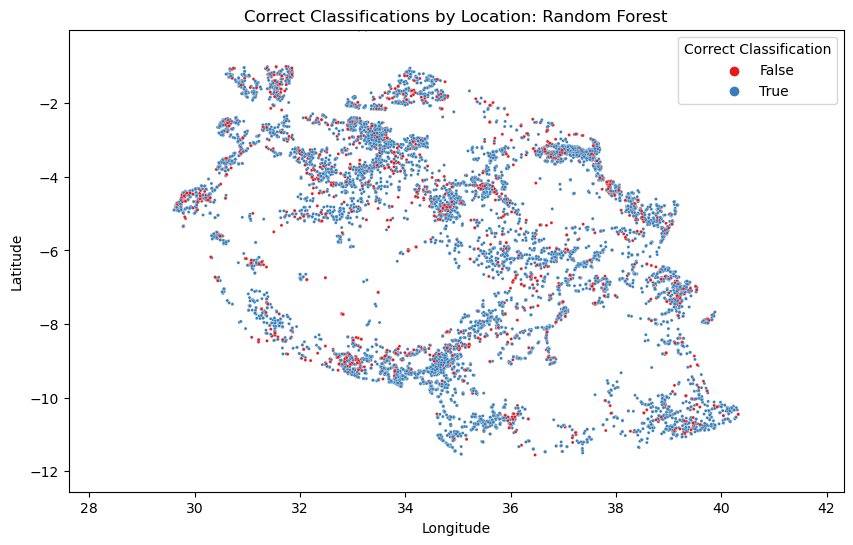

In [56]:
# plot classifications on map because it looks cool
lat_min = X_test_plot['latitude'].min() - 1
lat_max = X_test_plot['latitude'].max()
lon_min = X_test_plot.longitude[X_test_plot.longitude!=0].min() - 2
lon_max = X_test_plot['longitude'].max() + 2

plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue='correct_classification_rf', data=X_test_plot, palette='Set1', s=5)

# Set the range of latitude and longitude using computed min and max values
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title('Correct Classifications by Location: Random Forest')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Correct Classification')
plt.show()

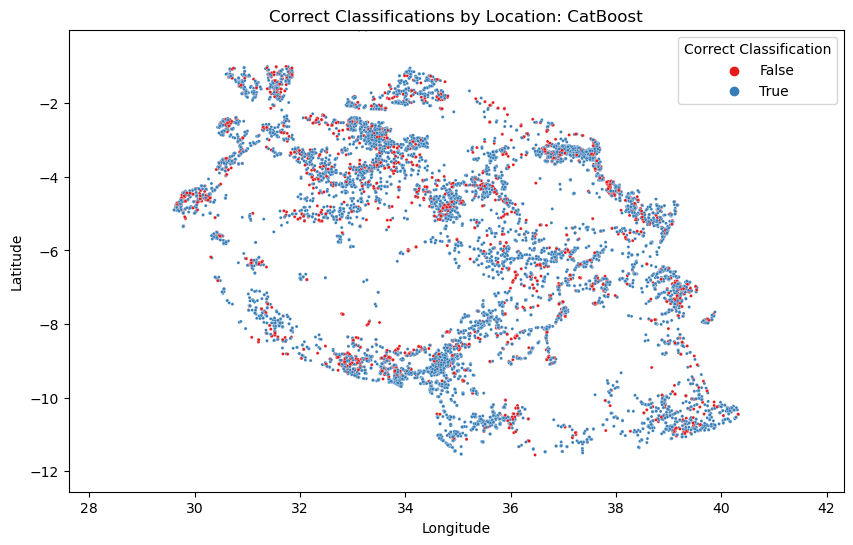

In [57]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue='correct_classification_cb', data=X_test_plot, palette='Set1', s=5)

# Set the range of latitude and longitude using computed min and max values
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title('Correct Classifications by Location: CatBoost')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Correct Classification')
plt.show()

**Extra Testing**

In [ ]:
# from sklearn.neural_network import MLPClassifier
# clf = MLPClassifier(random_state=1, max_iter=500).fit(X_train, y_train)
# y_test_mlp = clf.predict(X_test)
# accuracy = accuracy_score(y_test, y_test_mlp)
# print("Accuracy:", accuracy)

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier
# gb = GradientBoostingClassifier(n_estimators = 1000)
# gb_model = gb.fit(X_train, y_train)
# y_pred_gb = gb_model.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred_gb)
# print("Accuracy:", accuracy)


In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaled_X_train = scaler.fit_transform(X_train)
# scaled_X_test = scaler.fit_transform(X_test)

# from sklearn.decomposition import PCA
# pca = PCA(n_components=15)
# pca_X_train = pca.fit_transform(scaled_X_train)
# pca_X_test = pca.fit_transform(scaled_X_test)

In [ ]:
# # PCA TESTING
# model_rfc_pca = RandomForestClassifier(n_estimators=250, n_jobs = -1)
# model_rfc_pca.fit(pca_X_train,y_train)
# y_pred = model_rfc_pca.predict(pca_X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

In [ ]:
# from sklearn.naive_bayes import GaussianNB
# clf = GaussianNB()
# clf.fit(X_train, y_train)
# y_pred_gnb = clf.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred_gnb)
# print("Accuracy:", accuracy)

In [ ]:
# catboost_pca = CatBoostClassifier()
# catboost_pca.fit(pca_X_train, y_train,verbose=False)
# y_pred_cb = catboost_pca.predict(pca_X_test)
# accuracy = accuracy_score(y_test, y_pred_cb)
# print("Accuracy:", accuracy)

In [ ]:
# X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(train, label, test_size=0.3, random_state=42)

In [ ]:
# X_train_m["gps_height"].fillna(X_train_m.groupby(['region'])["gps_height"].transform("median"), inplace=True)
# X_train_m["gps_height"].fillna(X_train_m["gps_height"].mean(), inplace=True)

# X_train_m["population"].fillna(X_train_m.groupby(['region'])["population"].transform("median"), inplace=True)
# X_train_m["population"].fillna(X_train_m["population"].median(), inplace=True)

# X_train_m["amount_tsh"].fillna(X_train_m.groupby(['region'])["amount_tsh"].transform("median"), inplace=True)
# X_train_m["amount_tsh"].fillna(X_train_m["amount_tsh"].median(), inplace=True)


# X_train_m["waterpoint_age"].fillna(X_train_m.groupby(['region'])["waterpoint_age"].transform("median"), inplace=True)
# X_train_m["waterpoint_age"].fillna(X_train_m["waterpoint_age"].median(), inplace=True)

# X_train_m["longitude"].fillna(X_train_m.groupby(['region'])["longitude"].transform("median"), inplace=True)

In [ ]:
# X_test_m["gps_height"].fillna(X_test_m.groupby(['region'])["gps_height"].transform("median"), inplace=True)
# X_test_m["gps_height"].fillna(X_test_m["gps_height"].median(), inplace=True)

# X_test_m["population"].fillna(X_test_m.groupby(['region'])["population"].transform("median"), inplace=True)
# X_test_m["population"].fillna(X_test_m["population"].median(), inplace=True)

# X_test_m["amount_tsh"].fillna(X_test_m.groupby(['region'])["amount_tsh"].transform("median"), inplace=True)
# X_test_m["amount_tsh"].fillna(X_test_m["amount_tsh"].median(), inplace=True)


# X_test_m["waterpoint_age"].fillna(X_test_m.groupby(['region'])["waterpoint_age"].transform("median"), inplace=True)
# X_test_m["waterpoint_age"].fillna(X_test_m["waterpoint_age"].median(), inplace=True)

# X_test_m["longitude"].fillna(X_test_m.groupby(['region'])["longitude"].transform("median"), inplace=True)

In [ ]:
# rf_median = RandomForestClassifier(n_estimators=250,max_features='log2', n_jobs = -1)
# rf_median.fit(X_train_m,y_train_m)
# y_pred_median = rf_median.predict(X_test_m)
# accuracy = accuracy_score(y_test_m, y_pred_median)
# print("Accuracy:", accuracy)

In [ ]:
# rf = RandomForestClassifier(n_estimators=250,max_features='log2', n_jobs = -1)
# rf.fit(X_train,y_train)
# y_pred = rf_median.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred_median)
# print("Accuracy:", accuracy)

In [61]:
df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64